In [50]:
%load_ext autoreload
%autoreload 2

import numpy as np
import subprocess
import mdtraj as mdt
import shutil
from pathlib import Path

import sys
sys.path.append("../analysis/")
from chem_shift import run_faspr
from rg import gmx_gyrate
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ens_path = "/data/vschnapka/202310-CMAP-HPS/MeV-NT/MeV_NT_ens"
cmd = rf'find {ens_path}/ensemble_200_* -regex "^.*/[0-9]+a_132\.pdb$"'
res = subprocess.run(cmd, shell=True, capture_output=True, text=True)


In [7]:
import tempfile

faspr_bin = "/home/gzappavigna/FASPR/FASPR"

pdbs = [Path(pdb) for pdb in res.stdout.splitlines()]

frames = []

with tempfile.TemporaryDirectory() as tempdir_:
    tempdir = Path(tempdir_)

    for pdb_cg in pdbs:
        shutil.copy(pdb_cg, tempdir)
        pdb_cg = tempdir / pdb_cg.name
        assert pdb_cg.exists()

        pdb_all = tempdir / (pdb_cg.stem + "_all.pdb")
        subprocess.run([faspr_bin, "-i", str(pdb_cg), "-o", str(pdb_all)], check=True)
        assert pdb_all.exists()

        frames.append(mdt.load(pdb_all))



###########################################################################
                    FASPR (Version 20200309)                 
  A method for fast and accurate protein side-chain packing, 
which is an important problem in protein structure prediction
and protein design.

Copyright (c) 2020 Xiaoqiang Huang
Yang Zhang Lab
Dept. of Computational Medicine and Bioinformatics
Medical School
University of Michigan
Email:tommyhuangthu@foxmail.com, xiaoqiah@umich.edu
###########################################################################
#residues in pdb: 132
#alanines and glycines: 21
#residues fixed during self-energy-check: 2
iter 1 DEEgoldstein eliminates 944 rotamers
iter 2 DEEgoldstein eliminates 37 rotamers
iter 3 DEEgoldstein eliminates 3 rotamers
iter 4 DEEgoldstein eliminates 0 rotamers
#residues fixed after DEE-Goldstein: 89
#residues unfixed after DEE-Goldstein: 20
iter 1 DEEsplit eliminates 10 rotamers
iter 2 DEEsplit eliminates 2 rotamers
iter 3 DEEsplit eliminates 

In [9]:
ens_traj = mdt.join(frames)

In [12]:
ens_traj[0].save("prova.pdb")
ens_traj.save("prova.xtc")

In [30]:
rg = gmx_gyrate("prova.xtc", "prova.pdb")
rg = rg.reset_index()

27


In [47]:
rg = mdt.compute_rg(ens_traj)

In [48]:
rg

array([2.91033943, 3.82955603, 4.30337131, 4.50579254, 2.6602004 ,
       2.13603575, 3.33627557, 2.70561367, 3.93012851, 2.46669958,
       3.99181129, 3.42941792, 2.6694142 , 3.15194486, 6.25751279,
       2.63347851, 2.81355772, 3.43954899, 3.44282101, 3.45916687,
       4.33023568, 3.16093915, 3.00309159, 4.18190837, 3.09223482,
       2.20505509, 2.41177403, 2.54409643, 3.30955745, 2.16020739,
       3.05109219, 2.80565104, 3.09854658, 2.9736903 , 3.01115045,
       3.52657626, 2.64200176, 6.28145037, 3.10450494, 3.24220226,
       3.65083518, 4.4272187 , 2.90265271, 2.85484573, 4.46251892,
       2.68532311, 3.10169453, 2.71391157, 2.75591377, 3.18610128,
       3.67698042, 2.14085418, 4.49624776, 2.77680706, 4.44581703,
       2.59604344, 2.84942899, 3.03808903, 3.11706566, 3.33245321,
       3.66868191, 4.34128774, 2.71804377, 2.61307977, 2.84708778,
       3.964558  , 2.37614418, 3.51049654, 2.7116502 , 2.35767667,
       4.64204631, 3.09038379, 3.52922575, 4.69585487, 4.52353

In [53]:
idx = np.argsort(np.abs(rg - rg.mean()))[0]

In [34]:
# rg = rg.sort_values("Rg_delta")

In [39]:
# rg.index[0]

175

In [54]:
idx

175

In [55]:
closest_to_mean = ens_traj[idx]

In [57]:
mdt.compute_rg(closest_to_mean) - rg.mean()

array([-0.00044419])

(array([ 48., 204., 242., 221., 138.,  74.,  52.,  16.,   3.,   2.]),
 array([1.83655012, 2.28104014, 2.72553017, 3.17002019, 3.61451022,
        4.05900024, 4.50349027, 4.94798029, 5.39247032, 5.83696034,
        6.28145037]),
 <BarContainer object of 10 artists>)

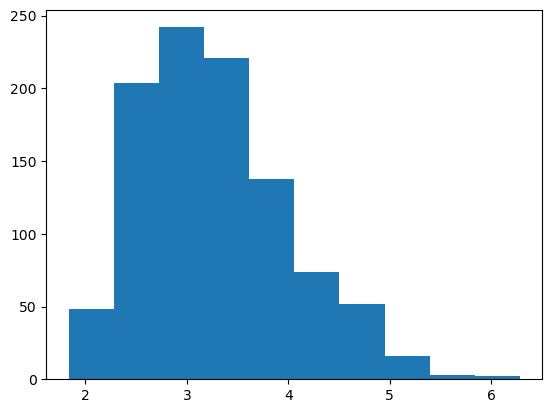

In [59]:
plt.hist(rg)

In [62]:
closest_to_mean.save("closest_to_rg_mean.pdb")

In [82]:
np.mean(rg)

3.279280816032738

In [69]:
from scipy.stats import mode

mode(np.round(rg, 1))

ModeResult(mode=3.1, count=67)

In [75]:
sasa = mdt.shrake_rupley(ens_traj)
total_sasa = sasa.sum(axis=1)

In [74]:
sasa.shape

(1000, 1027)

(array([  8.,  13.,  33.,  58., 112., 161., 221., 222., 132.,  40.]),
 array([122.69772339, 126.40473175, 130.11174011, 133.81874084,
        137.52575684, 141.23275757, 144.9397583 , 148.64677429,
        152.35377502, 156.06079102, 159.76779175]),
 <BarContainer object of 10 artists>)

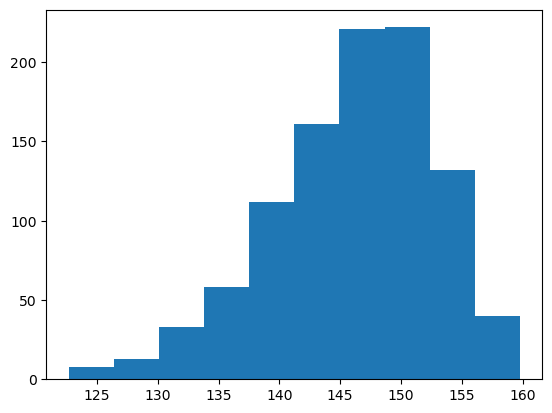

In [76]:
plt.hist(total_sasa)

In [78]:
total_sasa[175]

147.9391

In [79]:
total_sasa.mean()

146.03801